In [1]:
import requests
import os
from torch_geometric.data import Dataset
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv
import matplotlib.pyplot as plt
import numpy as np
import random
from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.utils import degree
from collections import Counter

In [2]:
class HW3Dataset(Dataset):
    url = 'https://technionmail-my.sharepoint.com/:u:/g/personal/ploznik_campus_technion_ac_il/EUHUDSoVnitIrEA6ALsAK1QBpphP5jX3OmGyZAgnbUFo0A?download=1'

    def __init__(self, root, transform=None, pre_transform=None):
        super(HW3Dataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return ['data.pt']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        file_url = self.url.replace(' ', '%20')
        response = requests.get(file_url)

        if response.status_code != 200:
            raise Exception(f"Failed to download the file, status code: {response.status_code}")

        with open(os.path.join(self.raw_dir, self.raw_file_names[0]), 'wb') as f:
            f.write(response.content)

    def process(self):
        raw_path = os.path.join(self.raw_dir, self.raw_file_names[0])
        data = torch.load(raw_path)
        torch.save(data, self.processed_paths[0])

    def len(self):
        return 1

    def get(self, idx):
        return torch.load(self.processed_paths[0])

In [3]:
dataset = HW3Dataset(root='data/hw3/')
data = dataset[0]
print(data)

Data(x=[100000, 128], edge_index=[2, 444288], y=[100000, 1], node_year=[100000, 1], train_mask=[80000], val_mask=[20000])


# Analysis

#### Visualize sample of the graph

/tmp/ipykernel_150802/2989804655.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, n_sample)


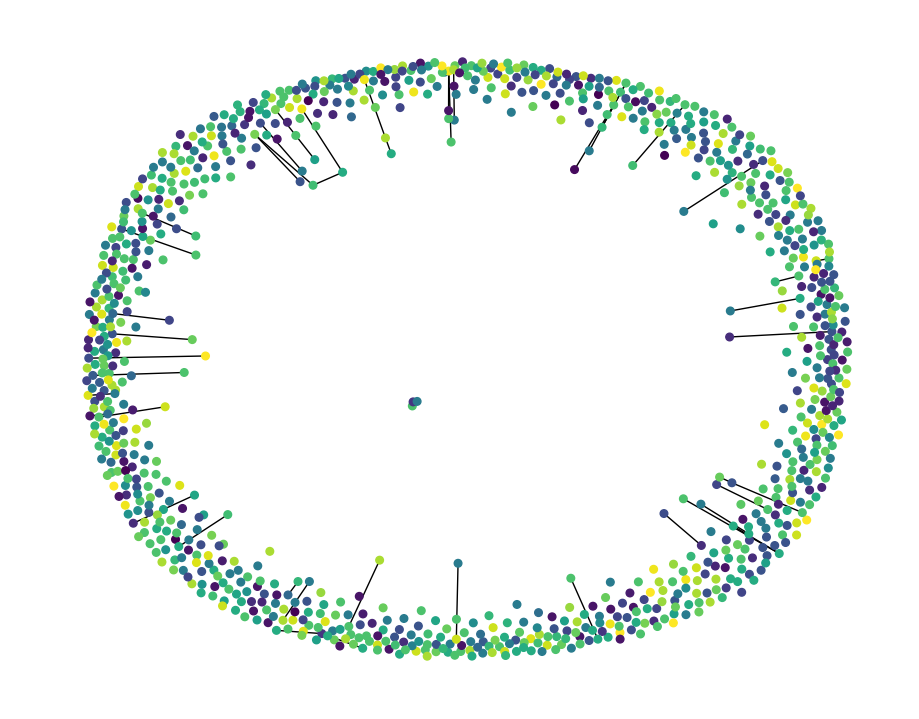

In [4]:
random.seed(21)

def convert_to_networkx(graph, n_sample=None):
    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):
    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.savefig("Visualization")
    plt.show()
    
    
g, y = convert_to_networkx(data, n_sample=1000)
plot_graph(g, y)

#### Gather some statistics about the graph

In [5]:
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')

print(f'Number of training nodes: {data.train_mask.shape[0]}')
print(f'Training node label rate: {int(data.train_mask.shape[0]) / data.num_nodes:.2f}')

Number of features: 128
Number of classes: 40
Number of nodes: 100000
Number of edges: 444288
Average node degree: 4.44
Has isolated nodes: True
Has self-loops: False
Number of training nodes: 80000
Training node label rate: 0.80


#### node degree

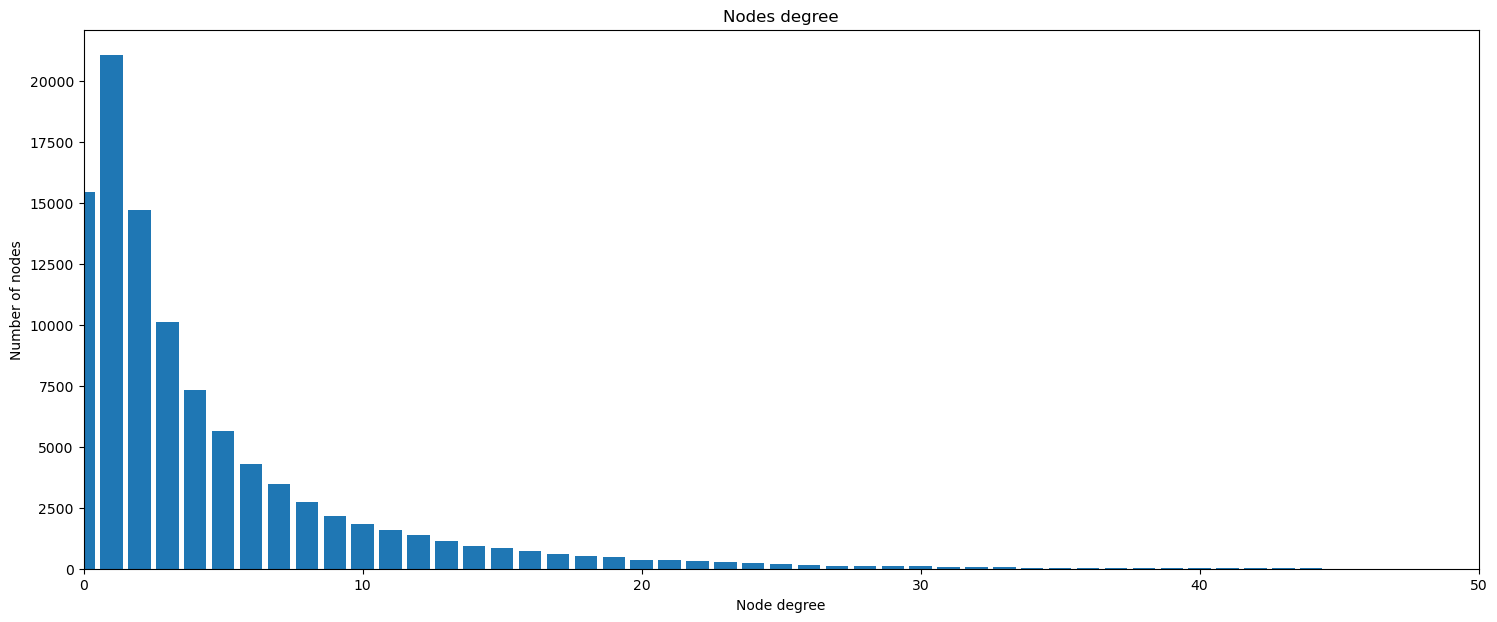

In [6]:
# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
ax.set_title('Nodes degree')
ax.set_xlim(0, 50)
plt.bar(numbers.keys(), numbers.values())
plt.savefig("nodes_degree")
plt.show()

In [7]:
print(f'Isolated nodes: {numbers[0]}')

Isolated nodes: 15442


#### node year

In [8]:
years = data.node_year.squeeze().numpy()

print("Minimum year:", years.min())
print("Maximum year:", years.max())

Minimum year: 1971
Maximum year: 2018


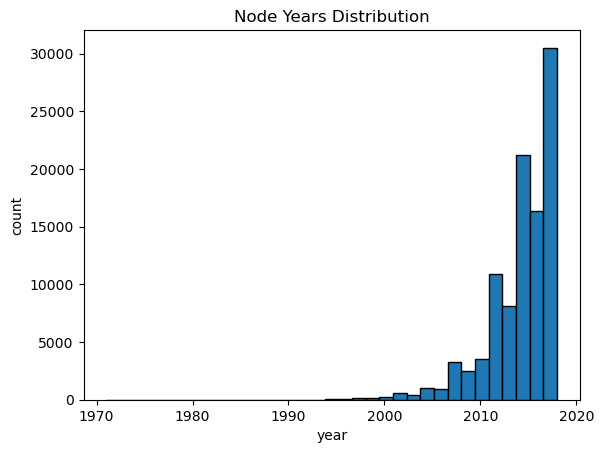

In [9]:
plt.hist(years, bins=len(np.unique(years)), edgecolor='black')
plt.title("Node Years Distribution")
plt.xlabel("year")
plt.ylabel("count")
plt.savefig("Years")
plt.show()

#### labels

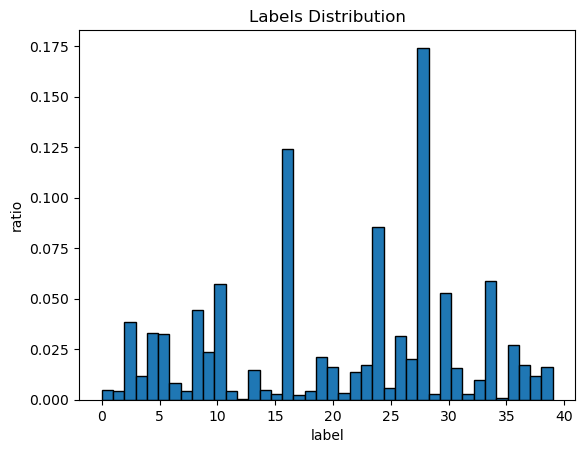

In [10]:
labels = data.y.squeeze().numpy()

plt.hist(labels, bins=len(np.unique(labels)), density=True, edgecolor='black')
plt.title("Labels Distribution")
plt.xlabel("label")
plt.ylabel("ratio")
plt.savefig("labels")
plt.show()

In [11]:
corr = np.corrcoef(years, labels)[0, 1]

print("Correlation coefficient of years and labels: ", round(corr, 3))

Correlation coefficient of years and labels:  0.011


## Preprocessing

In [12]:
features = data.x
features.shape

torch.Size([100000, 128])

In [13]:
# Normalize train node year
train_years = data.node_year[data.train_mask]
min_year = torch.min(train_years)
max_year = torch.max(train_years)
normalized_train_years = (train_years - min_year) / (max_year - min_year)
normalized_train_years = normalized_train_years.to(data.x.dtype)

# Normalize val node year
val_years = data.node_year[data.val_mask]
min_year = torch.min(val_years)
max_year = torch.max(val_years)
normalized_val_years = (val_years - min_year) / (max_year - min_year)
normalized_val_years = normalized_val_years.to(data.x.dtype)

# Concatenate
normalized_years = torch.cat((normalized_train_years, normalized_val_years), dim=0)
features = torch.cat((features, normalized_years), dim=1)

In [14]:
features.shape

torch.Size([100000, 129])

# Training

In [15]:
edge_index = data.edge_index
train_mask = data.train_mask
val_mask = data.val_mask
y = data.y.squeeze()

In [16]:
# Hyper parameters
epochs = 500
learning_rate = 0.005
hidden_channels = 12
num_heads = 15
dropout = 0.1

In [ ]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'  # CUDA out of memory
# torch.cuda.empty_cache()

In [ ]:
class GCN(torch.nn.Module):
    
    def __init__(self, hidden_channels):
        super().__init__()
        self.gcn1 = GCNConv(dataset.num_features + 1, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, dataset.num_classes)
    
    def forward(self, x, edge_index):
        x = F.dropout(x, p=dropout, training=self.training)
        x = self.gcn1(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=dropout, training=self.training)
        x = self.gcn2(x, edge_index)
        return x

In [17]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.norm = torch.nn.BatchNorm1d(dataset.num_features + 1)
        self.conv1 = GATConv(dataset.num_features + 1, hidden_channels, heads)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads)

    def forward(self, x, edge_index):
        x = self.norm(x)
        x = F.dropout(x, p=dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
class GAT2Conv(torch.nn.Module):
    def __init__(self, dim_h, heads):
        super().__init__()
        self.norm = torch.nn.BatchNorm1d(dataset.num_features + 1)
        self.gat1 = GATv2Conv(dataset.num_features + 1, dim_h, heads)
        self.gat2 = GATv2Conv(dim_h * heads, dataset.num_classes, heads)

    def forward(self, x, edge_index):
        x = self.norm(x)
        x = F.dropout(x, p=dropout, training=self.training)
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=dropout, training=self.training)
        x = self.gat2(x, edge_index)
        return x

In [24]:
def train_and_eval(model, optimizer, criterion):
    
    train_accuracies = []
    train_losses = []
    
    val_accuracies = []
    val_losses = []
    
    for epoch in range(epochs+1):
        
        # Training
        model.train()
        optimizer.zero_grad()
        out = model(features, edge_index)
        loss = criterion(out[train_mask], y[train_mask])
        loss.backward()
        optimizer.step()
        preds = out.argmax(dim=1)
        acc = ((preds[train_mask] == y[train_mask]).sum() / len(y[train_mask])).item()
        
        train_accuracies.append(acc)
        train_losses.append(loss.item())
        
        # Validation
        model.eval()
        val_loss = criterion(out[val_mask], y[val_mask])
        val_acc = ((preds[val_mask] == y[val_mask]).sum() / len(y[val_mask])).item()
        
        val_accuracies.append(val_acc)
        val_losses.append(val_loss.item())
        
        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: 'f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
        
    return train_accuracies, train_losses, val_accuracies, val_losses 

In [25]:
# model = GCN(hidden_channels)
model = GAT(hidden_channels, num_heads)
# model = GAT2Conv(hidden_channels, num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [26]:
train_accuracies, train_losses, val_accuracies, val_losses = train_and_eval(model, optimizer, criterion)

Epoch   0 | Train Loss: 6.480 | Train Acc:   0.10% | Val Loss: 6.50 | Val Acc: 0.08%
Epoch  10 | Train Loss: 2.181 | Train Acc:  47.00% | Val Loss: 2.23 | Val Acc: 46.60%
Epoch  20 | Train Loss: 1.698 | Train Acc:  54.84% | Val Loss: 1.83 | Val Acc: 52.52%
Epoch  30 | Train Loss: 1.542 | Train Acc:  56.98% | Val Loss: 1.69 | Val Acc: 53.94%
Epoch  40 | Train Loss: 1.465 | Train Acc:  58.48% | Val Loss: 1.59 | Val Acc: 55.52%
Epoch  50 | Train Loss: 1.426 | Train Acc:  59.50% | Val Loss: 1.56 | Val Acc: 56.15%


#### Save model

In [ ]:
# torch.save(model.state_dict(), './model.pkl')

#### Load model

In [ ]:
# model = GAT(hidden_channels, heads=num_heads)
# model.load_state_dict(torch.load('./model.pkl'))

## Graphs

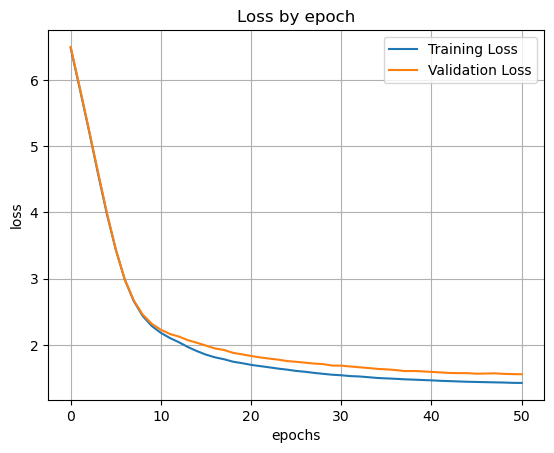

In [28]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss by epoch')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()
# plt.savefig('loss')
plt.show()

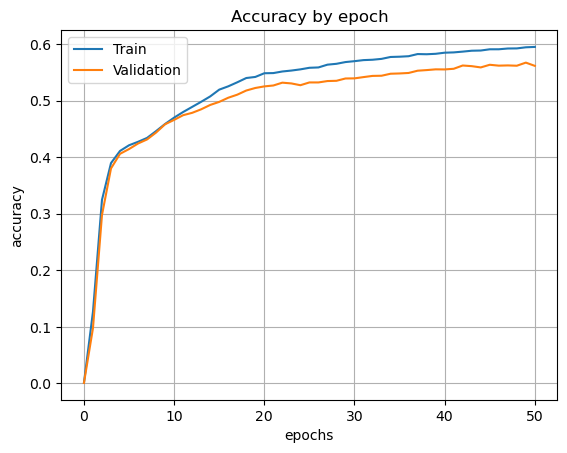

In [29]:
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy by epoch')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
# plt.savefig('accuracy')
plt.show()

##  Model accuracy for each degree

In [30]:
# model = model.to('cpu')

# Get model's classifications
out = model(features, edge_index)

# Calculate the degree of each node
degrees = degree(edge_index[0]).numpy()

In [31]:
# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    y = data.y[mask].squeeze()
    acc = ((out.argmax(dim=1)[mask] == y).sum() / len(y)).item()
    accuracies.append(acc)
    sizes.append(len(mask))
    
# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
y = data.y[mask].squeeze()
acc = ((out.argmax(dim=1)[mask] == y).sum() / len(y)).item()
accuracies.append(acc)
sizes.append(len(mask))

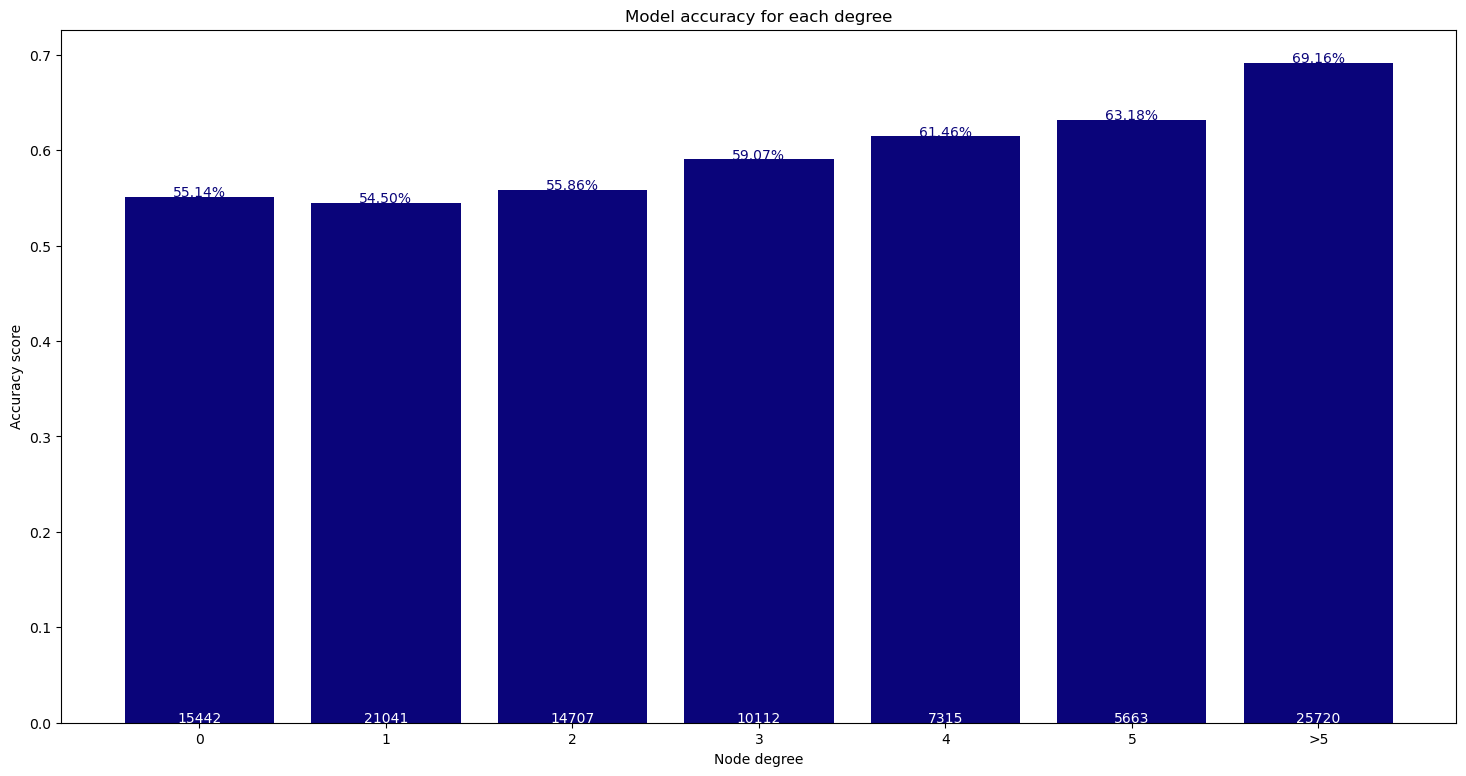

In [32]:
# Bar plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
ax.set_title('Model accuracy for each degree')

plt.bar(['0','1','2','3','4','5','>5'], accuracies, color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')
    
# plt.savefig('accuracy_degree')